##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MLMD Model Card Toolkit Demo

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/responsible_ai/model_card_toolkit/examples/MLMD_Model_Card_Toolkit_Demo"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/MLMD_Model_Card_Toolkit_Demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/model-card-toolkit/blob/master/model_card_toolkit/documentation/examples/MLMD_Model_Card_Toolkit_Demo.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/model-card-toolkit/model_card_toolkit/documentation/examples/MLMD_Model_Card_Toolkit_Demo.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Background

This notebook demonstrates how to generate a model card using the Model Card Toolkit with MLMD and TFX pipeline in a Jupyter/Colab environment. You can learn more about model cards at https://modelcards.withgoogle.com/about. 



## Setup
We first need to a) install and import the necessary packages, and b) download the data.

### Upgrade to Pip 21 (or later) and Install Model Card Toolkit

In [2]:
!pip install --upgrade pip==21.3
!pip install model-card-toolkit

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


####*Did you restart the runtime?*

If you are using Google Colab, the runtime must be restarted after installing new packages.

### Import packages

We import necessary packages, including standard TFX component classes and check the library versions.


In [3]:
import os
import pprint
import tempfile
import urllib

import absl
import random
import tensorflow.compat.v2 as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen
from tfx.components import Evaluator
from tfx.components import Pusher
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.components.base import executor_spec
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing

import ml_metadata as mlmd

Ensure TensorFlow 2 is running and executing eagerly.

In [4]:
tf.enable_v2_behavior()
tf.executing_eagerly()

True

In [5]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.version.__version__))
print('MLMD version: {}'.format(mlmd.__version__))

TensorFlow version: 2.7.1
TFX version: 1.5.0
MLMD version: 1.5.0


### Set up pipeline paths

In [6]:
# This is the root directory for your TFX pip package installation.
_tfx_root = tfx.__path__

# Set up logging.
absl.logging.set_verbosity(absl.logging.INFO)

### Download example data
We download the example dataset for use in our TFX pipeline.


In [7]:
DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/' \
   'adult.data'
_data_root = tempfile.mkdtemp(prefix='tfx-data')
_data_filepath = os.path.join(_data_root, "data.csv")
urllib.request.urlretrieve(DATA_PATH, _data_filepath)

columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

with open(_data_filepath, 'r') as f:
  content = f.read()
  content = content.replace(", <=50K", ', 0').replace(", >50K", ', 1')

with open(_data_filepath, 'w') as f:
  f.write(','.join(columns) + '\n' + content)

Take a quick look at the CSV file.

In [8]:
!head {_data_filepath}

Age,Workclass,fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-week,Country,Over-50K
39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, 0
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, 0
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, 0
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, 0
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, 0
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, 0
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, 0
52, Self-emp

### Create the InteractiveContext
Last, we create an InteractiveContext, which will allow us to run TFX components interactively in this notebook.

In [9]:
# Here, we create an InteractiveContext using default parameters. This will
# use a temporary directory with an ephemeral ML Metadata database instance.
# To use your own pipeline root or database, the optional properties
# `pipeline_root` and `metadata_connection_config` may be passed to
# InteractiveContext. Calls to InteractiveContext are no-ops outside of the
# notebook.
context = InteractiveContext(pipeline_name="Census Income Classification Pipeline")

## Run TFX components interactively
In the cells that follow, we create TFX components one-by-one, run each of them, and visualize their output artifacts. In this notebook, we won’t provide detailed explanations of each TFX component, but you can see what each does at [TFX Colab workshop](https://github.com/tensorflow/workshops/blob/master/tfx_labs/Lab_1_Pipeline_in_Colab.ipynb).

### ExampleGen

Create the `ExampleGen` component to split data into training and evaluation sets, convert the data into `tf.Example` format, and copy data into the `_tfx_root` directory for other components to access. 

In [10]:
example_gen = CsvExampleGen(input_base=_data_root)
context.run(example_gen)

INFO:absl:Running driver for CsvExampleGen


INFO:absl:MetadataStore with DB connection initialized


INFO:absl:select span and version = (0, None)


INFO:absl:latest span and version = (0, None)


INFO:absl:Running executor for CsvExampleGen


INFO:absl:Generating examples.


INFO:absl:Processing input csv data /tmpfs/tmp/tfx-datawz3771q2/* to TFExample.


INFO:absl:Examples generated.


INFO:absl:Running publisher for CsvExampleGen


INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 14
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/CsvExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "file_format"
          value {
            string_value: "tfrecords_gzip"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:3852053,xor_checksum:1651050640,sum_checksum:1651050640"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            int_value: 0
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        base_type: DATASET
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [11]:
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/CsvExampleGen/examples/1


Let’s take a look at the first three training examples:

In [12]:
# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 3 records and decode them.
for tfrecord in dataset.take(3):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

features {
  feature {
    key: "Age"
    value {
      int64_list {
        value: 39
      }
    }
  }
  feature {
    key: "Capital-Gain"
    value {
      int64_list {
        value: 2174
      }
    }
  }
  feature {
    key: "Capital-Loss"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "Country"
    value {
      bytes_list {
        value: " United-States"
      }
    }
  }
  feature {
    key: "Education"
    value {
      bytes_list {
        value: " Bachelors"
      }
    }
  }
  feature {
    key: "Education-Num"
    value {
      int64_list {
        value: 13
      }
    }
  }
  feature {
    key: "Hours-per-week"
    value {
      int64_list {
        value: 40
      }
    }
  }
  feature {
    key: "Marital-Status"
    value {
      bytes_list {
        value: " Never-married"
      }
    }
  }
  feature {
    key: "Occupation"
    value {
      bytes_list {
        value: " Adm-clerical"
      }
    }
  }
  feature {
    key: "Ov

### StatisticsGen

`StatisticsGen` takes as input the dataset we just ingested using `ExampleGen` and allows you to perform some analysis of your dataset using TensorFlow Data Validation (TFDV).

In [13]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])
context.run(statistics_gen)

INFO:absl:Excluding no splits because exclude_splits is not set.


INFO:absl:Running driver for StatisticsGen


INFO:absl:MetadataStore with DB connection initialized


INFO:absl:Running executor for StatisticsGen


INFO:absl:Generating statistics for split train.


INFO:absl:Statistics for split train written to /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/StatisticsGen/statistics/2/Split-train.


INFO:absl:Generating statistics for split eval.


INFO:absl:Statistics for split eval written to /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/StatisticsGen/statistics/2/Split-eval.


INFO:absl:Running publisher for StatisticsGen


INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 2
        type_id: 16
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/StatisticsGen/statistics/2"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 16
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        base_type: STATISTICS
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

After `StatisticsGen` finishes running, we can visualize the outputted statistics. Try playing with the different plots!

In [14]:
context.show(statistics_gen.outputs['statistics'])

### SchemaGen

`SchemaGen` will take as input the statistics that we generated with `StatisticsGen`, looking at the training split by default.

In [15]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False)
context.run(schema_gen)

INFO:absl:Excluding no splits because exclude_splits is not set.


INFO:absl:Running driver for SchemaGen


INFO:absl:MetadataStore with DB connection initialized


INFO:absl:Running executor for SchemaGen


INFO:absl:Processing schema from statistics for split train.


INFO:absl:Processing schema from statistics for split eval.


INFO:absl:Schema written to /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/SchemaGen/schema/3/schema.pbtxt.


INFO:absl:Running publisher for SchemaGen


INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 3
        type_id: 18
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/SchemaGen/schema/3"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 18
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [16]:
context.show(schema_gen.outputs['schema'])

Type  Presence Valency            Domain
Feature name                                                
'Age'                INT  required  single                 -
'Capital-Gain'       INT  required  single                 -
'Capital-Loss'       INT  required  single                 -
'Country'         STRING  required  single         'Country'
'Education'       STRING  required  single       'Education'
'Education-Num'      INT  required  single                 -
'Hours-per-week'     INT  required  single                 -
'Marital-Status'  STRING  required  single  'Marital-Status'
'Occupation'      STRING  required  single      'Occupation'
'Over-50K'           INT  required  single                 -
'Race'            STRING  required  single            'Race'
'Relationship'    STRING  required  single    'Relationship'
'Sex'             STRING  required  single             'Sex'
'Workclass'       STRING  required  single       'Workclass'
'fnlwgt'             INT  required  single                 -

Values
Domain                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
'Country'         ' ?', ' Cambodia', ' Canada', ' China', ' Columbia', ' Cuba', ' Dominican-Republic', ' Ecuador', ' El-Salvador', ' England', ' France', ' Germany', ' Greece', ' Guatemala', ' Haiti', ' Honduras', ' Hong', ' Hungary', ' India', ' Iran', ' Ireland', ' Italy', ' Jamaica', ' Japan', ' Laos', ' Mexico', ' Nicaragua', ' Outlying-US(Guam-USVI-etc)', ' Peru', ' Philippines', ' Poland', ' Portugal', ' Puerto-Rico', ' Scotland', ' South', ' Taiwan', ' Thailand', ' Trinadad&Tobago', ' United-States', ' Vietnam', ' Yugoslavia', ' Holand-Netherlands'
'Education'                                                                                                                                                                                                                                                                                                                                                                 ' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college'
'Marital-Status'                                                                                                                                                                                                                                                                                                                                                                                                                                   ' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed'
'Occupation'                                                                                                                                                                                                                                                                                             ' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving'
'Race'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other', ' White'
'Relationship'                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ' Husband', ' Not-in-family', ' Other-relative', ' Own-child', ' Unmarried', ' Wife'
'Sex'                                                      

To learn more about schemas, see [the SchemaGen documentation](https://www.tensorflow.org/tfx/guide/schemagen).

### Transform

`Transform` will take as input the data from `ExampleGen`, the schema from `SchemaGen`, as well as a module that contains user-defined Transform code.

Let's see an example of user-defined Transform code below (for an introduction to the TensorFlow Transform APIs, [see the tutorial](https://www.tensorflow.org/tfx/tutorials/transform/simple)).



In [17]:
_census_income_constants_module_file = 'census_income_constants.py'

In [18]:
%%writefile {_census_income_constants_module_file}

# Categorical features are assumed to each have a maximum value in the dataset.
MAX_CATEGORICAL_FEATURE_VALUES = [20]

CATEGORICAL_FEATURE_KEYS = ["Education-Num"]


DENSE_FLOAT_FEATURE_KEYS = ["Capital-Gain", "Hours-per-week", "Capital-Loss"]

# Number of buckets used by tf.transform for encoding each feature.
FEATURE_BUCKET_COUNT = 10

BUCKET_FEATURE_KEYS = ["Age"]

# Number of vocabulary terms used for encoding VOCAB_FEATURES by tf.transform
VOCAB_SIZE = 200

# Count of out-of-vocab buckets in which unrecognized VOCAB_FEATURES are hashed.
OOV_SIZE = 10

VOCAB_FEATURE_KEYS = ["Workclass", "Education", "Marital-Status", "Occupation", 
                      "Relationship", "Race", "Sex", "Country"]

# Keys
LABEL_KEY = "Over-50K"

def transformed_name(key):
  return key + '_xf'

Writing census_income_constants.py


In [19]:
_census_income_transform_module_file = 'census_income_transform.py'

In [20]:
%%writefile {_census_income_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

import census_income_constants

_DENSE_FLOAT_FEATURE_KEYS = census_income_constants.DENSE_FLOAT_FEATURE_KEYS
_VOCAB_FEATURE_KEYS = census_income_constants.VOCAB_FEATURE_KEYS
_VOCAB_SIZE = census_income_constants.VOCAB_SIZE
_OOV_SIZE = census_income_constants.OOV_SIZE
_FEATURE_BUCKET_COUNT = census_income_constants.FEATURE_BUCKET_COUNT
_BUCKET_FEATURE_KEYS = census_income_constants.BUCKET_FEATURE_KEYS
_CATEGORICAL_FEATURE_KEYS = census_income_constants.CATEGORICAL_FEATURE_KEYS
_LABEL_KEY = census_income_constants.LABEL_KEY
_transformed_name = census_income_constants.transformed_name


def preprocessing_fn(inputs):
  """tf.transform's callback function for preprocessing inputs.
  Args:
    inputs: map from feature keys to raw not-yet-transformed features.
  Returns:
    Map from string feature key to transformed feature operations.
  """
  outputs = {}
  for key in _DENSE_FLOAT_FEATURE_KEYS:
    # Preserve this feature as a dense float, setting nan's to the mean.
    outputs[_transformed_name(key)] = tft.scale_to_z_score(
        _fill_in_missing(inputs[key]))

  for key in _VOCAB_FEATURE_KEYS:
    # Build a vocabulary for this feature.
    outputs[_transformed_name(key)] = tft.compute_and_apply_vocabulary(
        _fill_in_missing(inputs[key]),
        top_k=_VOCAB_SIZE,
        num_oov_buckets=_OOV_SIZE)

  for key in _BUCKET_FEATURE_KEYS:
    outputs[_transformed_name(key)] = tft.bucketize(
        _fill_in_missing(inputs[key]), _FEATURE_BUCKET_COUNT)

  for key in _CATEGORICAL_FEATURE_KEYS:
    outputs[_transformed_name(key)] = _fill_in_missing(inputs[key])

  label = _fill_in_missing(inputs[_LABEL_KEY])
  outputs[_transformed_name(_LABEL_KEY)] = label
  
  return outputs


def _fill_in_missing(x):
  """Replace missing values in a SparseTensor.
  Fills in missing values of `x` with '' or 0, and converts to a dense tensor.
  Args:
    x: A `SparseTensor` of rank 2.  Its dense shape should have size at most 1
      in the second dimension.
  Returns:
    A rank 1 tensor where missing values of `x` have been filled in.
  """
  default_value = '' if x.dtype == tf.string else 0
  return tf.squeeze(
      tf.sparse.to_dense(
          tf.SparseTensor(x.indices, x.values, [x.dense_shape[0], 1]),
          default_value),
      axis=1)

Writing census_income_transform.py


In [21]:
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_census_income_transform_module_file))
context.run(transform)

INFO:absl:Generating ephemeral wheel package for '/tmpfs/src/temp/model_card_toolkit/documentation/examples/census_income_transform.py' (including modules: ['census_income_transform', 'census_income_constants']).


INFO:absl:User module package has hash fingerprint version 9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0.


INFO:absl:Executing: ['/tmpfs/src/tf_docs_env/bin/python', '/tmpfs/tmp/tmp6ykorptc/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmpfs/tmp/tmppxg6tk5f', '--dist-dir', '/tmpfs/tmp/tmpmcwpffer']


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying census_income_transform.py -> build/lib
copying census_income_constants.py -> build/lib


installing to /tmpfs/tmp/tmppxg6tk5f
running install
running install_lib
copying build/lib/census_income_transform.py -> /tmpfs/tmp/tmppxg6tk5f
copying build/lib/census_income_constants.py -> /tmpfs/tmp/tmppxg6tk5f
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info


writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
INFO:absl:Successfully built user code wheel distribution at '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl'; target user module is 'census_income_transform'.


INFO:absl:Full user module path is 'census_income_transform@/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl'


INFO:absl:Running driver for Transform


INFO:absl:MetadataStore with DB connection initialized


writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /tmpfs/tmp/tmppxg6tk5f/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3.7.egg-info
running install_scripts
creating /tmpfs/tmp/tmppxg6tk5f/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0.dist-info/WHEEL
creating '/tmpfs/tmp/tmpmcwpffer/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl' and adding '/tmpfs/tmp/tmppxg6tk5f' to it
adding 'census_income_constants.py'
adding 'census_income_transform.py'
adding 'tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0.dist-info/METADATA'


INFO:absl:Running executor for Transform


INFO:absl:Analyze the 'train' split and transform all splits when splits_config is not set.


INFO:absl:udf_utils.get_fn {'module_file': None, 'module_path': 'census_income_transform@/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl', 'preprocessing_fn': None} 'preprocessing_fn'


INFO:absl:Installing '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl' to a temporary directory.


INFO:absl:Executing: ['/tmpfs/src/tf_docs_env/bin/python', '-m', 'pip', 'install', '--target', '/tmpfs/tmp/tmpp2fgxex6', '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl']


Processing /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.
INFO:absl:Successfully installed '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl'.


INFO:absl:udf_utils.get_fn {'module_file': None, 'module_path': 'census_income_transform@/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl', 'stats_options_updater_fn': None} 'stats_options_updater_fn'


INFO:absl:Installing '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl' to a temporary directory.


INFO:absl:Executing: ['/tmpfs/src/tf_docs_env/bin/python', '-m', 'pip', 'install', '--target', '/tmpfs/tmp/tmp08sebpcy', '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl']


Processing /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.
INFO:absl:Successfully installed '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl'.


INFO:absl:Installing '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl' to a temporary directory.


INFO:absl:Executing: ['/tmpfs/src/tf_docs_env/bin/python', '-m', 'pip', 'install', '--target', '/tmpfs/tmp/tmpyzdmu59r', '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl']


Processing /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.
INFO:absl:Successfully installed '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Transform-0.0+9ad4c9c61fb069aa72a9c3dbadb0b29c6470126efbcfd2f85e87e9c2355a96d0-py3-none-any.whl'.


INFO:absl:Feature Age has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Gain has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Loss has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Country has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education-Num has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Hours-per-week has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Marital-Status has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Occupation has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Over-50K has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Race has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Relationship has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Sex has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Workclass has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature fnlwgt has no shape. Setting to VarLenSparseTensor.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


Instructions for updating:
Use ref() instead.


INFO:absl:Feature Age has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Gain has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Loss has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Country has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education-Num has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Hours-per-week has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Marital-Status has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Occupation has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Over-50K has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Race has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Relationship has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Sex has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Workclass has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature fnlwgt has no shape. Setting to VarLenSparseTensor.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:Feature Age has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Gain has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Loss has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Country has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education-Num has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Hours-per-week has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Marital-Status has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Occupation has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Over-50K has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Race has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Relationship has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Sex has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Workclass has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature fnlwgt has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Age has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Gain has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Loss has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Country has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education-Num has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Hours-per-week has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Marital-Status has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Occupation has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Over-50K has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Race has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Relationship has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Sex has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Workclass has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature fnlwgt has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Age has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Gain has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Loss has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Country has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education-Num has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Hours-per-week has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Marital-Status has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Occupation has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Over-50K has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Race has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Relationship has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Sex has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Workclass has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature fnlwgt has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Age has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Gain has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Loss has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Country has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education-Num has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Hours-per-week has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Marital-Status has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Occupation has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Over-50K has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Race has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Relationship has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Sex has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Workclass has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature fnlwgt has no shape. Setting to VarLenSparseTensor.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:Feature Age has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Gain has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Loss has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Country has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education-Num has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Hours-per-week has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Marital-Status has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Occupation has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Over-50K has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Race has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Relationship has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Sex has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Workclass has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature fnlwgt has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Age has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Gain has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Capital-Loss has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Country has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Education-Num has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Hours-per-week has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Marital-Status has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Occupation has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Over-50K has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Race has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Relationship has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Sex has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature Workclass has no shape. Setting to VarLenSparseTensor.


INFO:absl:Feature fnlwgt has no shape. Setting to VarLenSparseTensor.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


2022-04-27 09:11:17.569552: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Transform/transform_graph/4/.temp_path/tftransform_tmp/3ec9e5378ce447b5b7959c94b9b4bfda/assets


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Transform/transform_graph/4/.temp_path/tftransform_tmp/3ebfabff57b2413b9071df6af8e0070b/assets


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:absl:If the number of unique tokens is smaller than the provided top_k or approximation error is acceptable, consider using tft.experimental.approximate_vocabulary for a potentially more efficient implementation.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:absl:Running publisher for Transform


INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: Transform
    execution_id: 4
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 4
        type_id: 20
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Transform/transform_graph/4"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 20
        name: "TransformGraph"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 5
        type_id: 14
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Transform/transformed_examples/4"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        base_type: DATASET
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 6
        type_id: 21
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Transform/updated_analyzer_cache/4"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 21
        name: "TransformCache"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        pre_transform_schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 7
        type_id: 18
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Transform/pre_transform_schema/4"
        custom_properties {
          key: "name"
          value {
            string_value: "pre_transform_schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
         

In [22]:
transform.outputs['transform_graph']

Channel(
    type_name: TransformGraph
    artifacts: [Artifact(artifact: id: 4
type_id: 20
uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Transform/transform_graph/4"
custom_properties {
  key: "name"
  value {
    string_value: "transform_graph"
  }
}
custom_properties {
  key: "producer_component"
  value {
    string_value: "Transform"
  }
}
custom_properties {
  key: "state"
  value {
    string_value: "published"
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.5.0"
  }
}
state: LIVE
, artifact_type: id: 20
name: "TransformGraph"
)]
    additional_properties: {}
    additional_custom_properties: {}
)

### Trainer
Let's see an example of user-defined model code below (for an introduction to the TensorFlow Keras APIs, [see the tutorial](https://www.tensorflow.org/guide/keras)):

In [23]:
_census_income_trainer_module_file = 'census_income_trainer.py'

In [24]:
%%writefile {_census_income_trainer_module_file}

from typing import List, Text

import os
import absl
import datetime
import tensorflow as tf
import tensorflow_transform as tft

from tfx.components.trainer.executor import TrainerFnArgs

import census_income_constants

_DENSE_FLOAT_FEATURE_KEYS = census_income_constants.DENSE_FLOAT_FEATURE_KEYS
_VOCAB_FEATURE_KEYS = census_income_constants.VOCAB_FEATURE_KEYS
_VOCAB_SIZE = census_income_constants.VOCAB_SIZE
_OOV_SIZE = census_income_constants.OOV_SIZE
_FEATURE_BUCKET_COUNT = census_income_constants.FEATURE_BUCKET_COUNT
_BUCKET_FEATURE_KEYS = census_income_constants.BUCKET_FEATURE_KEYS
_CATEGORICAL_FEATURE_KEYS = census_income_constants.CATEGORICAL_FEATURE_KEYS
_MAX_CATEGORICAL_FEATURE_VALUES = census_income_constants.MAX_CATEGORICAL_FEATURE_VALUES
_LABEL_KEY = census_income_constants.LABEL_KEY
_transformed_name = census_income_constants.transformed_name


def _transformed_names(keys):
  return [_transformed_name(key) for key in keys]


def _gzip_reader_fn(filenames):
  """Small utility returning a record reader that can read gzip'ed files."""
  return tf.data.TFRecordDataset(
      filenames,
      compression_type='GZIP')


def _get_serve_tf_examples_fn(model, tf_transform_output):
  """Returns a function that parses a serialized tf.Example and applies TFT."""

  model.tft_layer = tf_transform_output.transform_features_layer()

  @tf.function
  def serve_tf_examples_fn(serialized_tf_examples):
    """Returns the output to be used in the serving signature."""
    feature_spec = tf_transform_output.raw_feature_spec()
    feature_spec.pop(_LABEL_KEY)
    parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)

    transformed_features = model.tft_layer(parsed_features)
    if _transformed_name(_LABEL_KEY) in transformed_features:
      transformed_features.pop(_transformed_name(_LABEL_KEY))

    return model(transformed_features)

  return serve_tf_examples_fn


def _input_fn(file_pattern: List[Text],
              tf_transform_output: tft.TFTransformOutput,
              batch_size: int = 200) -> tf.data.Dataset:
  """Generates features and label for tuning/training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    tf_transform_output: A TFTransformOutput.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  transformed_feature_spec = (
      tf_transform_output.transformed_feature_spec().copy())

  dataset = tf.data.experimental.make_batched_features_dataset(
      file_pattern=file_pattern,
      batch_size=batch_size,
      features=transformed_feature_spec,
      reader=_gzip_reader_fn,
      label_key=_transformed_name(_LABEL_KEY))

  return dataset


def _build_keras_model(hidden_units: List[int] = None) -> tf.keras.Model:
  """Creates a DNN Keras model.

  Args:
    hidden_units: [int], the layer sizes of the DNN (input layer first).

  Returns:
    A keras Model.
  """
  real_valued_columns = [
      tf.feature_column.numeric_column(key, shape=())
      for key in _transformed_names(_DENSE_FLOAT_FEATURE_KEYS)
  ]
  categorical_columns = [
      tf.feature_column.categorical_column_with_identity(
          key, num_buckets=_VOCAB_SIZE + _OOV_SIZE, default_value=0)
      for key in _transformed_names(_VOCAB_FEATURE_KEYS)
  ]
  categorical_columns += [
      tf.feature_column.categorical_column_with_identity(
          key, num_buckets=_FEATURE_BUCKET_COUNT, default_value=0)
      for key in _transformed_names(_BUCKET_FEATURE_KEYS)
  ]
  categorical_columns += [
      tf.feature_column.categorical_column_with_identity(  # pylint: disable=g-complex-comprehension
          key,
          num_buckets=num_buckets,
          default_value=0) for key, num_buckets in zip(
              _transformed_names(_CATEGORICAL_FEATURE_KEYS),
              _MAX_CATEGORICAL_FEATURE_VALUES)
  ]
  indicator_column = [
      tf.feature_column.indicator_column(categorical_column)
      for categorical_column in categorical_columns
  ]

  model = _wide_and_deep_classifier(
      # TODO(b/139668410) replace with premade wide_and_deep keras model
      wide_columns=indicator_column,
      deep_columns=real_valued_columns,
      dnn_hidden_units=hidden_units or [100, 70, 50, 25])
  return model


def _wide_and_deep_classifier(wide_columns, deep_columns, dnn_hidden_units):
  """Build a simple keras wide and deep model.

  Args:
    wide_columns: Feature columns wrapped in indicator_column for wide (linear)
      part of the model.
    deep_columns: Feature columns for deep part of the model.
    dnn_hidden_units: [int], the layer sizes of the hidden DNN.

  Returns:
    A Wide and Deep Keras model
  """
  # Following values are hard coded for simplicity in this example,
  # However prefarably they should be passsed in as hparams.

  # Keras needs the feature definitions at compile time.
  # TODO(b/139081439): Automate generation of input layers from FeatureColumn.
  input_layers = {
      colname: tf.keras.layers.Input(name=colname, shape=(), dtype=tf.float32)
      for colname in _transformed_names(_DENSE_FLOAT_FEATURE_KEYS)
  }
  input_layers.update({
      colname: tf.keras.layers.Input(name=colname, shape=(), dtype='int32')
      for colname in _transformed_names(_VOCAB_FEATURE_KEYS)
  })
  input_layers.update({
      colname: tf.keras.layers.Input(name=colname, shape=(), dtype='int32')
      for colname in _transformed_names(_BUCKET_FEATURE_KEYS)
  })
  input_layers.update({
      colname: tf.keras.layers.Input(name=colname, shape=(), dtype='int32')
      for colname in _transformed_names(_CATEGORICAL_FEATURE_KEYS)
  })

  # TODO(b/161816639): SparseFeatures for feature columns + Keras.
  deep = tf.keras.layers.DenseFeatures(deep_columns)(input_layers)
  for numnodes in dnn_hidden_units:
    deep = tf.keras.layers.Dense(numnodes)(deep)
  wide = tf.keras.layers.DenseFeatures(wide_columns)(input_layers)

  output = tf.keras.layers.Dense(
      1, activation='sigmoid')(
          tf.keras.layers.concatenate([deep, wide]))

  model = tf.keras.Model(input_layers, output)
  model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.Adam(lr=0.001),
      metrics=[tf.keras.metrics.BinaryAccuracy()])
  model.summary(print_fn=absl.logging.info)
  return model


# TFX Trainer will call this function.
def run_fn(fn_args: TrainerFnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """
  # Number of nodes in the first layer of the DNN
  first_dnn_layer_size = 100
  num_dnn_layers = 4
  dnn_decay_factor = 0.7

  tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)

  train_dataset = _input_fn(fn_args.train_files, tf_transform_output, 40)
  eval_dataset = _input_fn(fn_args.eval_files, tf_transform_output, 40)

  model = _build_keras_model(
      # Construct layers sizes with exponetial decay
      hidden_units=[
          max(2, int(first_dnn_layer_size * dnn_decay_factor**i))
          for i in range(num_dnn_layers)
      ])

  # This log path might change in the future.
  log_dir = os.path.join(os.path.dirname(fn_args.serving_model_dir), 'logs')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
     log_dir=log_dir, update_freq='batch')
  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks=[tensorboard_callback])

  signatures = {
      'serving_default':
          _get_serve_tf_examples_fn(model,
                                    tf_transform_output).get_concrete_function(
                                        tf.TensorSpec(
                                            shape=[None],
                                            dtype=tf.string,
                                            name='examples')),
  }
  model.save(fn_args.serving_model_dir, save_format='tf', signatures=signatures)

Writing census_income_trainer.py


In [25]:
trainer = Trainer(
    module_file=os.path.abspath(_census_income_trainer_module_file),
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(num_steps=100),
    eval_args=trainer_pb2.EvalArgs(num_steps=50))
context.run(trainer)

INFO:absl:Generating ephemeral wheel package for '/tmpfs/src/temp/model_card_toolkit/documentation/examples/census_income_trainer.py' (including modules: ['census_income_transform', 'census_income_trainer', 'census_income_constants']).


INFO:absl:User module package has hash fingerprint version aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe.


INFO:absl:Executing: ['/tmpfs/src/tf_docs_env/bin/python', '/tmpfs/tmp/tmpwqql_i8g/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmpfs/tmp/tmpzpmolcsr', '--dist-dir', '/tmpfs/tmp/tmpnkgc7yz1']


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying census_income_transform.py -> build/lib
copying census_income_trainer.py -> build/lib
copying census_income_constants.py -> build/lib


installing to /tmpfs/tmp/tmpzpmolcsr
running install
running install_lib
copying build/lib/census_income_transform.py -> /tmpfs/tmp/tmpzpmolcsr
copying build/lib/census_income_trainer.py -> /tmpfs/tmp/tmpzpmolcsr
copying build/lib/census_income_constants.py -> /tmpfs/tmp/tmpzpmolcsr
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info


writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
INFO:absl:Successfully built user code wheel distribution at '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3-none-any.whl'; target user module is 'census_income_trainer'.


INFO:absl:Full user module path is 'census_income_trainer@/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3-none-any.whl'


INFO:absl:Running driver for Trainer


INFO:absl:MetadataStore with DB connection initialized


writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /tmpfs/tmp/tmpzpmolcsr/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3.7.egg-info
running install_scripts
creating /tmpfs/tmp/tmpzpmolcsr/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe.dist-info/WHEEL
creating '/tmpfs/tmp/tmpnkgc7yz1/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3-none-any.whl' and adding '/tmpfs/tmp/tmpzpmolcsr' to it
adding 'census_income_constants.py'
adding 'census_income_trainer.py'
adding 'census_income_transform.py'
adding 'tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe.dist

INFO:absl:Running executor for Trainer


INFO:absl:Train on the 'train' split when train_args.splits is not set.


INFO:absl:Evaluate on the 'eval' split when eval_args.splits is not set.


INFO:absl:udf_utils.get_fn {'train_args': '{\n  "num_steps": 100\n}', 'eval_args': '{\n  "num_steps": 50\n}', 'module_file': None, 'run_fn': None, 'trainer_fn': None, 'custom_config': 'null', 'module_path': 'census_income_trainer@/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3-none-any.whl'} 'run_fn'


INFO:absl:Installing '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3-none-any.whl' to a temporary directory.


INFO:absl:Executing: ['/tmpfs/src/tf_docs_env/bin/python', '-m', 'pip', 'install', '--target', '/tmpfs/tmp/tmpj80rqe5y', '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3-none-any.whl']


Processing /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3-none-any.whl


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.
INFO:absl:Successfully installed '/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/_wheels/tfx_user_code_Trainer-0.0+aa1f5233b0e0a112365f42ff9488eec93da45611d414b4dc3c0a3a28e1aaa3fe-py3-none-any.whl'.


INFO:absl:Training model.


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
INFO:absl:Model: "model"


INFO:absl:__________________________________________________________________________________________________


INFO:absl: Layer (type)                   Output Shape         Param #     Connected to                     


INFO:absl:==================================================================================================


INFO:absl: Age_xf (InputLayer)            [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: Capital-Gain_xf (InputLayer)   [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: Capital-Loss_xf (InputLayer)   [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: Country_xf (InputLayer)        [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: Education-Num_xf (InputLayer)  [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: Education_xf (InputLayer)      [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: Hours-per-week_xf (InputLayer)  [(None,)]           0           []                               


INFO:absl:                                                                                                  


INFO:absl: Marital-Status_xf (InputLayer)  [(None,)]           0           []                               


INFO:absl:                                                                                                  


INFO:absl: Occupation_xf (InputLayer)     [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: Race_xf (InputLayer)           [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: Relationship_xf (InputLayer)   [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: Sex_xf (InputLayer)            [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: Workclass_xf (InputLayer)      [(None,)]            0           []                               


INFO:absl:                                                                                                  


INFO:absl: dense_features (DenseFeatures)  (None, 3)           0           ['Age_xf[0][0]',                 


INFO:absl:                                                                  'Capital-Gain_xf[0][0]',        


INFO:absl:                                                                  'Capital-Loss_xf[0][0]',        


INFO:absl:                                                                  'Country_xf[0][0]',             


INFO:absl:                                                                  'Education-Num_xf[0][0]',       


INFO:absl:                                                                  'Education_xf[0][0]',           


INFO:absl:                                                                  'Hours-per-week_xf[0][0]',      


INFO:absl:                                                                  'Marital-Status_xf[0][0]',      


INFO:absl:                                                                  'Occupation_xf[0][0]',          


INFO:absl:                                                                  'Race_xf[0][0]',                


INFO:absl:                                                                  'Relationship_xf[0][0]',        


INFO:absl:                                                                  'Sex_xf[0][0]',                 


INFO:absl:                                                                  'Workclass_xf[0][0]']           


INFO:absl:                                                                                                  


INFO:absl: dense (Dense)                  (None, 100)          400         ['dense_features[0][0]']         


INFO:absl:                                                                                                  


INFO:absl: dense_1 (Dense)                (None, 70)           7070        ['dense[0][0]']                  


INFO:absl:                                                                                                  


INFO:absl: dense_2 (Dense)                (None, 48)           3408        ['dense_1[0][0]']                


INFO:absl:                                                                                                  


INFO:absl: dense_3 (Dense)                (None, 34)           1666        ['dense_2[0][0]']                


INFO:absl:                                                                                                  


INFO:absl: dense_features_1 (DenseFeature  (None, 1710)        0           ['Age_xf[0][0]',                 


INFO:absl: s)                                                               'Capital-Gain_xf[0][0]',        


INFO:absl:                                                                  'Capital-Loss_xf[0][0]',        


INFO:absl:                                                                  'Country_xf[0][0]',             


INFO:absl:                                                                  'Education-Num_xf[0][0]',       


INFO:absl:                                                                  'Education_xf[0][0]',           


INFO:absl:                                                                  'Hours-per-week_xf[0][0]',      


INFO:absl:                                                                  'Marital-Status_xf[0][0]',      


INFO:absl:                                                                  'Occupation_xf[0][0]',          


INFO:absl:                                                                  'Race_xf[0][0]',                


INFO:absl:                                                                  'Relationship_xf[0][0]',        


INFO:absl:                                                                  'Sex_xf[0][0]',                 


INFO:absl:                                                                  'Workclass_xf[0][0]']           


INFO:absl:                                                                                                  


INFO:absl: concatenate (Concatenate)      (None, 1744)         0           ['dense_3[0][0]',                


INFO:absl:                                                                  'dense_features_1[0][0]']       


INFO:absl:                                                                                                  


INFO:absl: dense_4 (Dense)                (None, 1)            1745        ['concatenate[0][0]']            


INFO:absl:                                                                                                  


INFO:absl:==================================================================================================


INFO:absl:Total params: 14,289


INFO:absl:Trainable params: 14,289


INFO:absl:Non-trainable params: 0


INFO:absl:__________________________________________________________________________________________________


  1/100 [..............................] - ETA: 3:37 - loss: 0.6884 - binary_accuracy: 0.5750

  9/100 [=>............................] - ETA: 0s - loss: 0.6558 - binary_accuracy: 0.6722  

 18/100 [====>.........................] - ETA: 0s - loss: 0.6151 - binary_accuracy: 0.7097

 27/100 [=======>......................] - ETA: 0s - loss: 0.5784 - binary_accuracy: 0.7380

 35/100 [=========>....................] - ETA: 0s - loss: 0.5542 - binary_accuracy: 0.7521

 44/100 [============>.................] - ETA: 0s - loss: 0.5199 - binary_accuracy: 0.7750

 52/100 [==============>...............] - ETA: 0s - loss: 0.5171 - binary_accuracy: 0.7774

 60/100 [=================>............] - ETA: 0s - loss: 0.5117 - binary_accuracy: 0.7804

 68/100 [===================>..........] - ETA: 0s - loss: 0.5068 - binary_accuracy: 0.7816

 76/100 [=====================>........] - ETA: 0s - loss: 0.5062 - binary_accuracy: 0.7783

 84/100 [========================>.....] - ETA: 0s - loss: 0.5004 - binary_accuracy: 0.7818

 92/100 [==========================>...] - ETA: 0s - loss: 0.4963 - binary_accuracy: 0.7829

100/100 [==============================] - ETA: 0s - loss: 0.4904 - binary_accuracy: 0.7855

100/100 [==============================] - 4s 14ms/step - loss: 0.4904 - binary_accuracy: 0.7855 - val_loss: 0.4341 - val_binary_accuracy: 0.8115


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Trainer/model/5/Format-Serving/assets


INFO:absl:Training complete. Model written to /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Trainer/model/5/Format-Serving. ModelRun written to /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Trainer/model_run/5


INFO:absl:Running publisher for Trainer


INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: Trainer
    execution_id: 5
    outputs:
        model: Channel(
            type_name: Model
            artifacts: [Artifact(artifact: id: 12
        type_id: 24
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Trainer/model/5"
        custom_properties {
          key: "name"
          value {
            string_value: "model"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Trainer"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 24
        name: "Model"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        model_run: Channel(
            type_name: ModelRun
            artifacts: [Artifact(artifact: id: 13
        type_id: 25
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Trainer/model_run/5"
        custom_properties {
          key: "name"
          value {
            string_value: "model_run"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Trainer"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 25
        name: "ModelRun"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [26]:
trainer.outputs

{'model': Channel(
     type_name: Model
     artifacts: [Artifact(artifact: id: 12
 type_id: 24
 uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Trainer/model/5"
 custom_properties {
   key: "name"
   value {
     string_value: "model"
   }
 }
 custom_properties {
   key: "producer_component"
   value {
     string_value: "Trainer"
   }
 }
 custom_properties {
   key: "state"
   value {
     string_value: "published"
   }
 }
 custom_properties {
   key: "tfx_version"
   value {
     string_value: "1.5.0"
   }
 }
 state: LIVE
 , artifact_type: id: 24
 name: "Model"
 )]
     additional_properties: {}
     additional_custom_properties: {}
 ),
 'model_run': Channel(
     type_name: ModelRun
     artifacts: [Artifact(artifact: id: 13
 type_id: 25
 uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Trainer/model_run/5"
 custom_properties {
   key: "name"
   value {
     string_value: "model_run"
   }
 }
 custom_properties {
   key: "producer_component"
 

### Evaluator
The `Evaluator` component computes model performance metrics over the evaluation set. It uses the [TensorFlow Model Analysis](https://www.tensorflow.org/tfx/model_analysis/get_started) library. 

`Evaluator` will take as input the data from `ExampleGen`, the trained model from `Trainer`, and slicing configuration. The slicing configuration allows you to slice your metrics on feature values. See an example of this configuration below:

In [27]:
from google.protobuf.wrappers_pb2 import BoolValue

eval_config = tfma.EvalConfig(
    model_specs=[
        # This assumes a serving model with signature 'serving_default'. If
        # using estimator based EvalSavedModel, add signature_name: 'eval' and 
        # remove the label_key.
        tfma.ModelSpec(label_key="Over-50K")
    ],
    metrics_specs=[
        tfma.MetricsSpec(
            # The metrics added here are in addition to those saved with the
            # model (assuming either a keras model or EvalSavedModel is used).
            # Any metrics added into the saved model (for example using
            # model.compile(..., metrics=[...]), etc) will be computed
            # automatically.
            # To add validation thresholds for metrics saved with the model,
            # add them keyed by metric name to the thresholds map.
            metrics=[
                tfma.MetricConfig(class_name='ExampleCount'),
                tfma.MetricConfig(class_name='BinaryAccuracy'),
                tfma.MetricConfig(class_name='FairnessIndicators',
                                  config='{ "thresholds": [0.5] }'),
            ]
        )
    ],
    slicing_specs=[
        # An empty slice spec means the overall slice, i.e. the whole dataset.
        tfma.SlicingSpec(),
        # Data can be sliced along a feature column. In this case, data is
        # sliced by feature column Race and Sex.
        tfma.SlicingSpec(feature_keys=['Race']),
        tfma.SlicingSpec(feature_keys=['Sex']),
        tfma.SlicingSpec(feature_keys=['Race', 'Sex']),
    ],
    options = tfma.Options(compute_confidence_intervals=BoolValue(value=True))
)

Warning: the Evaluator Component may take 5-10 minutes to run due to errors regarding "inconsistent references". 

In [28]:
# Use TFMA to compute a evaluation statistics over features of a model and
# validate them against a baseline.

# TODO(b/226656838) Fix the inconsistent references warnings.
evaluator = Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    eval_config=eval_config)
context.run(evaluator)

INFO:absl:Running driver for Evaluator


INFO:absl:MetadataStore with DB connection initialized


INFO:absl:Running executor for Evaluator


INFO:absl:Nonempty beam arg extra_packages already includes dependency


INFO:absl:udf_utils.get_fn {'eval_config': '{\n  "metrics_specs": [\n    {\n      "metrics": [\n        {\n          "class_name": "ExampleCount"\n        },\n        {\n          "class_name": "BinaryAccuracy"\n        },\n        {\n          "class_name": "FairnessIndicators",\n          "config": "{ \\"thresholds\\": [0.5] }"\n        }\n      ]\n    }\n  ],\n  "model_specs": [\n    {\n      "label_key": "Over-50K"\n    }\n  ],\n  "options": {\n    "compute_confidence_intervals": true\n  },\n  "slicing_specs": [\n    {},\n    {\n      "feature_keys": [\n        "Race"\n      ]\n    },\n    {\n      "feature_keys": [\n        "Sex"\n      ]\n    },\n    {\n      "feature_keys": [\n        "Race",\n        "Sex"\n      ]\n    }\n  ]\n}', 'feature_slicing_spec': None, 'fairness_indicator_thresholds': 'null', 'example_splits': 'null', 'module_file': None, 'module_path': None} 'custom_eval_shared_model'


INFO:absl:Request was made to ignore the baseline ModelSpec and any change thresholds. This is likely because a baseline model was not provided: updated_config=
model_specs {
  label_key: "Over-50K"
}
slicing_specs {
}
slicing_specs {
  feature_keys: "Race"
}
slicing_specs {
  feature_keys: "Sex"
}
slicing_specs {
  feature_keys: "Race"
  feature_keys: "Sex"
}
metrics_specs {
  metrics {
    class_name: "ExampleCount"
  }
  metrics {
    class_name: "BinaryAccuracy"
  }
  metrics {
    class_name: "FairnessIndicators"
    config: "{ \"thresholds\": [0.5] }"
  }
}
options {
  compute_confidence_intervals {
    value: true
  }
  confidence_intervals {
    method: JACKKNIFE
  }
}



INFO:absl:Using /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Trainer/model/5/Format-Serving as  model.



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f49ad48c2d0> and <keras.engine.input_layer.InputLayer object at 0x7f48005301d0>).


INFO:absl:The 'example_splits' parameter is not set, using 'eval' split.


INFO:absl:Evaluating model.


INFO:absl:udf_utils.get_fn {'eval_config': '{\n  "metrics_specs": [\n    {\n      "metrics": [\n        {\n          "class_name": "ExampleCount"\n        },\n        {\n          "class_name": "BinaryAccuracy"\n        },\n        {\n          "class_name": "FairnessIndicators",\n          "config": "{ \\"thresholds\\": [0.5] }"\n        }\n      ]\n    }\n  ],\n  "model_specs": [\n    {\n      "label_key": "Over-50K"\n    }\n  ],\n  "options": {\n    "compute_confidence_intervals": true\n  },\n  "slicing_specs": [\n    {},\n    {\n      "feature_keys": [\n        "Race"\n      ]\n    },\n    {\n      "feature_keys": [\n        "Sex"\n      ]\n    },\n    {\n      "feature_keys": [\n        "Race",\n        "Sex"\n      ]\n    }\n  ]\n}', 'feature_slicing_spec': None, 'fairness_indicator_thresholds': 'null', 'example_splits': 'null', 'module_file': None, 'module_path': None} 'custom_extractors'


INFO:absl:Request was made to ignore the baseline ModelSpec and any change thresholds. This is likely because a baseline model was not provided: updated_config=
model_specs {
  label_key: "Over-50K"
}
slicing_specs {
}
slicing_specs {
  feature_keys: "Race"
}
slicing_specs {
  feature_keys: "Sex"
}
slicing_specs {
  feature_keys: "Race"
  feature_keys: "Sex"
}
metrics_specs {
  metrics {
    class_name: "ExampleCount"
  }
  metrics {
    class_name: "BinaryAccuracy"
  }
  metrics {
    class_name: "FairnessIndicators"
    config: "{ \"thresholds\": [0.5] }"
  }
  model_names: ""
}
options {
  compute_confidence_intervals {
    value: true
  }
  confidence_intervals {
    method: JACKKNIFE
  }
}



INFO:absl:Request was made to ignore the baseline ModelSpec and any change thresholds. This is likely because a baseline model was not provided: updated_config=
model_specs {
  label_key: "Over-50K"
}
slicing_specs {
}
slicing_specs {
  feature_keys: "Race"
}
slicing_specs {
  feature_keys: "Sex"
}
slicing_specs {
  feature_keys: "Race"
  feature_keys: "Sex"
}
metrics_specs {
  metrics {
    class_name: "ExampleCount"
  }
  metrics {
    class_name: "BinaryAccuracy"
  }
  metrics {
    class_name: "FairnessIndicators"
    config: "{ \"thresholds\": [0.5] }"
  }
  model_names: ""
}
options {
  compute_confidence_intervals {
    value: true
  }
  confidence_intervals {
    method: JACKKNIFE
  }
}



INFO:absl:Request was made to ignore the baseline ModelSpec and any change thresholds. This is likely because a baseline model was not provided: updated_config=
model_specs {
  label_key: "Over-50K"
}
slicing_specs {
}
slicing_specs {
  feature_keys: "Race"
}
slicing_specs {
  feature_keys: "Sex"
}
slicing_specs {
  feature_keys: "Race"
  feature_keys: "Sex"
}
metrics_specs {
  metrics {
    class_name: "ExampleCount"
  }
  metrics {
    class_name: "BinaryAccuracy"
  }
  metrics {
    class_name: "FairnessIndicators"
    config: "{ \"thresholds\": [0.5] }"
  }
  model_names: ""
}
options {
  compute_confidence_intervals {
    value: true
  }
  confidence_intervals {
    method: JACKKNIFE
  }
}




Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f499c6a02d0> and <keras.engine.input_layer.InputLayer object at 0x7f471c402990>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f46fc38e050> and <keras.engine.input_layer.InputLayer object at 0x7f46fc3cd0d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4993eb72d0> and <keras.engine.input_layer.InputLayer object at 0x7f48005cf910>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4898291450> and <keras.engine.input_layer.InputLayer object at 0x7f471c635b90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f46c4408f50> and <keras.engine.input_layer.InputLayer object at 0x7f46c4453b50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f46466f7890> and <keras.engine.input_layer.InputLayer object at 0x7f4646733b50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4644f58cd0> and <keras.engine.input_layer.InputLayer object at 0x7f4645068210>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4644148710> and <keras.engine.input_layer.InputLayer object at 0x7f46c446ae10>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4245492f50> and <keras.engine.input_layer.InputLayer object at 0x7f42454d8b10>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4244641f90> and <keras.engine.input_layer.InputLayer object at 0x7f4244609bd0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f423f6905d0> and <keras.engine.input_layer.InputLayer object at 0x7f423f7a6190>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f423e8c24d0> and <keras.engine.input_layer.InputLayer object at 0x7f423e8ddc10>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f423d9c6f50> and <keras.engine.input_layer.InputLayer object at 0x7f423da0ead0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f423cb6b490> and <keras.engine.input_layer.InputLayer object at 0x7f423cbbfe10>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4223bcd850> and <keras.engine.input_layer.InputLayer object at 0x7f423cb13d90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4222e030d0> and <keras.engine.input_layer.InputLayer object at 0x7f4222e12310>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4221f0bb10> and <keras.engine.input_layer.InputLayer object at 0x7f4221f51810>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f42210b0690> and <keras.engine.input_layer.InputLayer object at 0x7f4221084590>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4220126750> and <keras.engine.input_layer.InputLayer object at 0x7f4220235d90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f41fb19e0d0> and <keras.engine.input_layer.InputLayer object at 0x7f41fb1f49d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f41fa44a910> and <keras.engine.input_layer.InputLayer object at 0x7f41fa495f50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f41f8549890> and <keras.engine.input_layer.InputLayer object at 0x7f41f850bfd0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4179781610> and <keras.engine.input_layer.InputLayer object at 0x7f41797da990>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4178855810> and <keras.engine.input_layer.InputLayer object at 0x7f417888d890>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f414b966a90> and <keras.engine.input_layer.InputLayer object at 0x7f414b94f090>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f414a9f94d0> and <keras.engine.input_layer.InputLayer object at 0x7f414aa31810>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4149aa5510> and <keras.engine.input_layer.InputLayer object at 0x7f4149afe8d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4148d5d810> and <keras.engine.input_layer.InputLayer object at 0x7f4148d92850>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4143e1cf50> and <keras.engine.input_layer.InputLayer object at 0x7f4143e62950>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4142e1d910> and <keras.engine.input_layer.InputLayer object at 0x7f4142e6a790>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4141ee57d0> and <keras.engine.input_layer.InputLayer object at 0x7f4141f38650>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4140f52650> and <keras.engine.input_layer.InputLayer object at 0x7f4141022ad0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f414001ad90> and <keras.engine.input_layer.InputLayer object at 0x7f414005bf50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f41031a6d10> and <keras.engine.input_layer.InputLayer object at 0x7f41031bcf90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4143eef6d0> and <keras.engine.input_layer.InputLayer object at 0x7f4148ec9590>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4100f7bd50> and <keras.engine.input_layer.InputLayer object at 0x7f4100ed3c90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40e3f7c9d0> and <keras.engine.input_layer.InputLayer object at 0x7f40e3ee6950>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40e3090710> and <keras.engine.input_layer.InputLayer object at 0x7f40e30bb250>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40e20cbe90> and <keras.engine.input_layer.InputLayer object at 0x7f40e2082750>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40e12aa710> and <keras.engine.input_layer.InputLayer object at 0x7f40e1221810>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40e02e0310> and <keras.engine.input_layer.InputLayer object at 0x7f40e02f7a10>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d74aca90> and <keras.engine.input_layer.InputLayer object at 0x7f40d734cc10>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d64bc8d0> and <keras.engine.input_layer.InputLayer object at 0x7f40d64f25d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d5608a50> and <keras.engine.input_layer.InputLayer object at 0x7f40d5546090>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d46a6a50> and <keras.engine.input_layer.InputLayer object at 0x7f40d46f23d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d37e6fd0> and <keras.engine.input_layer.InputLayer object at 0x7f40d381ced0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d2842050> and <keras.engine.input_layer.InputLayer object at 0x7f40d2887810>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d1923dd0> and <keras.engine.input_layer.InputLayer object at 0x7f40d195f590>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d09e5b50> and <keras.engine.input_layer.InputLayer object at 0x7f40d0a27b90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40cfa51a50> and <keras.engine.input_layer.InputLayer object at 0x7f40cfa87a50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40ceb09f90> and <keras.engine.input_layer.InputLayer object at 0x7f40ceb54c50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40cdb1a690> and <keras.engine.input_layer.InputLayer object at 0x7f40cdb643d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f423ce15310> and <keras.engine.input_layer.InputLayer object at 0x7f423f6b3550>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40cc202350> and <keras.engine.input_layer.InputLayer object at 0x7f40cc1c1f50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40cb25bb50> and <keras.engine.input_layer.InputLayer object at 0x7f40cb225d90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40ca414650> and <keras.engine.input_layer.InputLayer object at 0x7f40ca3402d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c943b850> and <keras.engine.input_layer.InputLayer object at 0x7f40c9413c10>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c8b60290> and <keras.engine.input_layer.InputLayer object at 0x7f40c8a6e550>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c7bb3110> and <keras.engine.input_layer.InputLayer object at 0x7f40c7bf7910>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c6caa4d0> and <keras.engine.input_layer.InputLayer object at 0x7f40c6cf5190>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c5da5950> and <keras.engine.input_layer.InputLayer object at 0x7f40c5def7d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c4e7ccd0> and <keras.engine.input_layer.InputLayer object at 0x7f40c4eba850>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c3f28a50> and <keras.engine.input_layer.InputLayer object at 0x7f40c3f61a90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c2ffcb10> and <keras.engine.input_layer.InputLayer object at 0x7f40c3036cd0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c206df10> and <keras.engine.input_layer.InputLayer object at 0x7f40c2169a10>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c118d410> and <keras.engine.input_layer.InputLayer object at 0x7f40c11534d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40c02b8810> and <keras.engine.input_layer.InputLayer object at 0x7f40c111a0d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f42238f6510> and <keras.engine.input_layer.InputLayer object at 0x7f41fb2bff90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f423da6ab10> and <keras.engine.input_layer.InputLayer object at 0x7f4223daf310>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4245111550> and <keras.engine.input_layer.InputLayer object at 0x7f4244646e90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f46fc11a050> and <keras.engine.input_layer.InputLayer object at 0x7f46fc2e9d50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4993f132d0> and <keras.engine.input_layer.InputLayer object at 0x7f46fc2f8190>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f423dca6450> and <keras.engine.input_layer.InputLayer object at 0x7f41fb3ce310>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4644f1ab50> and <keras.engine.input_layer.InputLayer object at 0x7f4644f103d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f423fcc5910> and <keras.engine.input_layer.InputLayer object at 0x7f4245484710>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f423c958f50> and <keras.engine.input_layer.InputLayer object at 0x7f422351b0d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f422275c650> and <keras.engine.input_layer.InputLayer object at 0x7f4220c98490>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4644b46510> and <keras.engine.input_layer.InputLayer object at 0x7f4644c1f750>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4221afbed0> and <keras.engine.input_layer.InputLayer object at 0x7f4223796590>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f414b96dcd0> and <keras.engine.input_layer.InputLayer object at 0x7f41431a5f50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4222baee10> and <keras.engine.input_layer.InputLayer object at 0x7f4222ab9710>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4221518410> and <keras.engine.input_layer.InputLayer object at 0x7f4221b0b9d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f42451d14d0> and <keras.engine.input_layer.InputLayer object at 0x7f4645550050>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f423f431f50> and <keras.engine.input_layer.InputLayer object at 0x7f423f47a9d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4223732b50> and <keras.engine.input_layer.InputLayer object at 0x7f422376cd50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4220a2e690> and <keras.engine.input_layer.InputLayer object at 0x7f4220a75410>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f41f9e9f850> and <keras.engine.input_layer.InputLayer object at 0x7f41f9f33710>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40becc6b50> and <keras.engine.input_layer.InputLayer object at 0x7f40bed138d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40cf148150> and <keras.engine.input_layer.InputLayer object at 0x7f40d1015c50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d29e9f10> and <keras.engine.input_layer.InputLayer object at 0x7f40d2c37cd0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d70e50d0> and <keras.engine.input_layer.InputLayer object at 0x7f40d6c42910>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40e3232710> and <keras.engine.input_layer.InputLayer object at 0x7f40e22895d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4148316650> and <keras.engine.input_layer.InputLayer object at 0x7f4142a029d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f417846d590> and <keras.engine.input_layer.InputLayer object at 0x7f414a8a1a10>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40e062c290> and <keras.engine.input_layer.InputLayer object at 0x7f40d6b25310>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4143dd2fd0> and <keras.engine.input_layer.InputLayer object at 0x7f4141fbe150>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40ce91d110> and <keras.engine.input_layer.InputLayer object at 0x7f40ce290810>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40cfc7c6d0> and <keras.engine.input_layer.InputLayer object at 0x7f4149781250>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f414a6f8250> and <keras.engine.input_layer.InputLayer object at 0x7f41433f9250>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40cf4c9210> and <keras.engine.input_layer.InputLayer object at 0x7f40cf16b6d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f414848c750> and <keras.engine.input_layer.InputLayer object at 0x7f4148a776d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40e0b71950> and <keras.engine.input_layer.InputLayer object at 0x7f40e0b26890>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f414a0e7990> and <keras.engine.input_layer.InputLayer object at 0x7f414be51a90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d0f63250> and <keras.engine.input_layer.InputLayer object at 0x7f40d14ec1d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d2cdff50> and <keras.engine.input_layer.InputLayer object at 0x7f4148337d50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d209af50> and <keras.engine.input_layer.InputLayer object at 0x7f40e0c22050>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d05f7290> and <keras.engine.input_layer.InputLayer object at 0x7f40d44e6490>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d402d050> and <keras.engine.input_layer.InputLayer object at 0x7f40d4e5fdd0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f414ac9e8d0> and <keras.engine.input_layer.InputLayer object at 0x7f414accfbd0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d4112f10> and <keras.engine.input_layer.InputLayer object at 0x7f40d43c2c50>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4101a65cd0> and <keras.engine.input_layer.InputLayer object at 0x7f40d61bd150>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f417942ef50> and <keras.engine.input_layer.InputLayer object at 0x7f4179479990>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f414a5457d0> and <keras.engine.input_layer.InputLayer object at 0x7f414a750610>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4143601a50> and <keras.engine.input_layer.InputLayer object at 0x7f414377ac10>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4102633610> and <keras.engine.input_layer.InputLayer object at 0x7f41026093d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40e112a4d0> and <keras.engine.input_layer.InputLayer object at 0x7f40e113f250>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d461cd10> and <keras.engine.input_layer.InputLayer object at 0x7f40d455a750>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40d0808110> and <keras.engine.input_layer.InputLayer object at 0x7f40d085dad0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40bdf44590> and <keras.engine.input_layer.InputLayer object at 0x7f40bdf904d0>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40bd0a99d0> and <keras.engine.input_layer.InputLayer object at 0x7f40bd0e3c90>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40bc232090> and <keras.engine.input_layer.InputLayer object at 0x7f40bc26c250>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f40bb26af50> and <keras.engine.input_layer.InputLayer object at 0x7f40bb2a0290>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f414bf80450> and <keras.engine.input_layer.InputLayer object at 0x7f4824302450>).



Two checkpoint references resolved to different objects (<keras.saving.saved_model.load.TensorFlowTransform>TransformFeaturesLayer object at 0x7f4646281050> and <keras.engine.input_layer.InputLayer object at 0x7f464c7b39d0>).


INFO:absl:Evaluation complete. Results written to /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Evaluator/evaluation/6.


INFO:absl:No threshold configured, will not validate model.


INFO:absl:Running publisher for Evaluator


INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: Evaluator
    execution_id: 6
    outputs:
        evaluation: Channel(
            type_name: ModelEvaluation
            artifacts: [Artifact(artifact: id: 14
        type_id: 27
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Evaluator/evaluation/6"
        custom_properties {
          key: "name"
          value {
            string_value: "evaluation"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Evaluator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 27
        name: "ModelEvaluation"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        blessing: Channel(
            type_name: ModelBlessing
            artifacts: [Artifact(artifact: id: 15
        type_id: 28
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Evaluator/blessing/6"
        custom_properties {
          key: "name"
          value {
            string_value: "blessing"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Evaluator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 28
        name: "ModelBlessing"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [29]:
evaluator.outputs

{'evaluation': Channel(
     type_name: ModelEvaluation
     artifacts: [Artifact(artifact: id: 14
 type_id: 27
 uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Evaluator/evaluation/6"
 custom_properties {
   key: "name"
   value {
     string_value: "evaluation"
   }
 }
 custom_properties {
   key: "producer_component"
   value {
     string_value: "Evaluator"
   }
 }
 custom_properties {
   key: "state"
   value {
     string_value: "published"
   }
 }
 custom_properties {
   key: "tfx_version"
   value {
     string_value: "1.5.0"
   }
 }
 state: LIVE
 , artifact_type: id: 27
 name: "ModelEvaluation"
 )]
     additional_properties: {}
     additional_custom_properties: {}
 ),
 'blessing': Channel(
     type_name: ModelBlessing
     artifacts: [Artifact(artifact: id: 15
 type_id: 28
 uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Evaluator/blessing/6"
 custom_properties {
   key: "name"
   value {
     string_value: "blessing"
   }
 }
 custom_

Using the `evaluation` output we can show the default visualization of global metrics on the entire evaluation set.

In [30]:
context.show(evaluator.outputs['evaluation'])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


###Model Card Generator
The `Model Card` component is a [TFX Component](https://www.tensorflow.org/tfx/guide/understanding_tfx_pipelines#component) that generates model cards-- short documentation that provides key information about a machine learning model-- from the StatisticGen outputs, the Evaluator outputs, and a prepared json annotation. Optionally, a pushed model or a template can be provided as well. 

The model cards assets are saved to a ModelCard artifact that can be fetched from the `outputs['model_card]'` property.

#### Prepare Annotation Json for Model Card

It is also important to document model information that might be important to downstream users, such as its limitations, intended use cases, trade offs, and ethical considerations. Thus, we will prepare this information in json format to be used in the model card generating step.

In [31]:
import json
import model_card_toolkit as mctlib

model_card_json = {'model_details': {'name': 'Census Income Classifier'}, 
                   'model_details': {'overview': 
                      'This is a wide and deep Keras model which aims to classify whether or not '
                      'an individual has an income of over $50,000 based on various demographic '
                      'features. The model is trained on the UCI Census Income Dataset. This is '
                      'not a production model, and this dataset has traditionally only been used '
                      'for research purposes. In this Model Card, you can review quantitative '
                      'components of the model’s performance and data, as well as information '
                      'about the model’s intended uses, limitations, and ethical considerations.'},
                   'model_details': {'owners': [{"name": "Model Cards Team", "contact": "model-cards@google.com"}]},
                   'considerations': {'use_cases':[{"description":'This dataset that this model was trained on was originally created to '
                      'support the machine learning community in conducting empirical analysis '
                      'of ML algorithms. The Adult Data Set can be used in fairness-related '
                      'studies that compare inequalities across sex and race, based on '
                      'people’s annual incomes.'}]},
                   'considerations': {'limitations': [{'description':
                      'This is a class-imbalanced dataset across a variety of sensitive classes.'
                      ' The ratio of male-to-female examples is about 2:1 and there are far more'
                      ' examples with the “white” attribute than every other race combined. '
                      'Furthermore, the ratio of $50,000 or less earners to $50,000 or more '
                      'earners is just over 3:1. Due to the imbalance across income levels, we '
                      'can see that our true negative rate seems quite high, while our true '
                      'positive rate seems quite low. This is true to an even greater degree '
                      'when we only look at the “female” sub-group, because there are even '
                      'fewer female examples in the $50,000+ earner group, causing our model to '
                      'overfit these examples. To avoid this, we can try various remediation '
                      'strategies in future iterations (e.g. undersampling, hyperparameter '
                      'tuning, etc), but we may not be able to fix all of the fairness issues.'}]}, 
                    'considerations': {'ethical_considerations': [
                                        {'name': 'We risk expressing the viewpoint that the attributes in this dataset '
                                                  'are the only ones that are predictive of someone’s income, even '
                                                  'though we know this is not the case.', 
                                         'mitigation_strategy': 'As mentioned, some interventions may need to be '
                                            'performed to address the class imbalances in the dataset.'}]}
                  }

#### Generate the Model Card.


In [32]:
from model_card_toolkit.tfx.component import ModelCardGenerator

mct_gen = ModelCardGenerator(statistics=statistics_gen.outputs['statistics'],
                             evaluation=evaluator.outputs['evaluation'],
                             json=json.dumps(model_card_json))
context.run(mct_gen)


INFO:absl:Running driver for ModelCardGenerator


INFO:absl:MetadataStore with DB connection initialized


INFO:absl:Running executor for ModelCardGenerator


INFO:absl:EvalResult found at path /tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/Evaluator/evaluation/6


INFO:absl:Reading stats artifact from Split-train


INFO:absl:Reading stats artifact from Split-eval


INFO:absl:Running publisher for ModelCardGenerator


INFO:absl:MetadataStore with DB connection initialized


ExecutionResult(
    component_id: ModelCardGenerator
    execution_id: 7
    outputs:
        model_card: Channel(
            type_name: ModelCard
            artifacts: [Artifact(artifact: id: 16
        type_id: 30
        uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/ModelCardGenerator/model_card/7"
        custom_properties {
          key: "name"
          value {
            string_value: "model_card"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ModelCardGenerator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 30
        name: "ModelCard"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [33]:
mct_gen.outputs['model_card']

Channel(
    type_name: ModelCard
    artifacts: [Artifact(artifact: id: 16
type_id: 30
uri: "/tmpfs/tmp/tfx-Census Income Classification Pipeline-9ikbb3ld/ModelCardGenerator/model_card/7"
custom_properties {
  key: "name"
  value {
    string_value: "model_card"
  }
}
custom_properties {
  key: "producer_component"
  value {
    string_value: "ModelCardGenerator"
  }
}
custom_properties {
  key: "state"
  value {
    string_value: "published"
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.5.0"
  }
}
state: LIVE
, artifact_type: id: 30
name: "ModelCard"
)]
    additional_properties: {}
    additional_custom_properties: {}
)

##Display Model Card

Lastly, we isolate the uri from the model card generator artifact and use it to display the model card.

['template', 'model_cards', 'data']



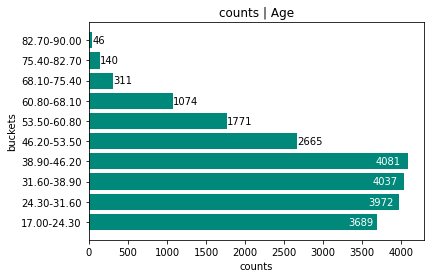
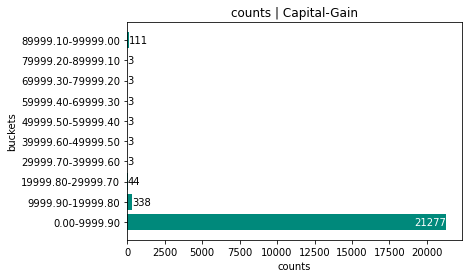
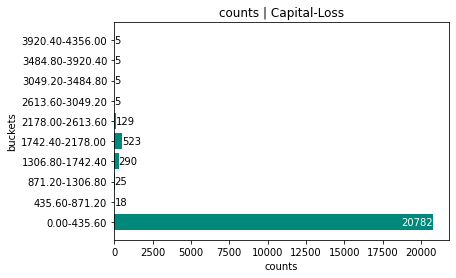
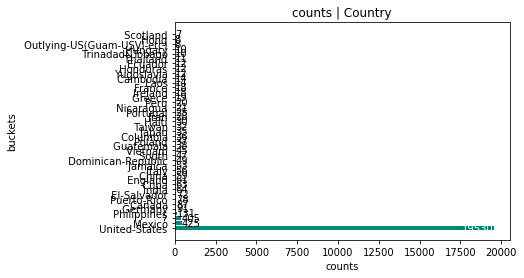
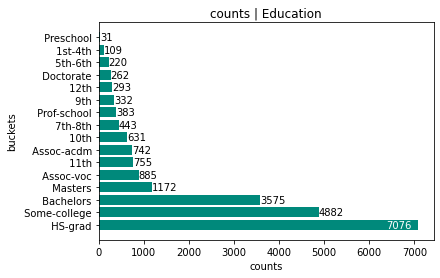
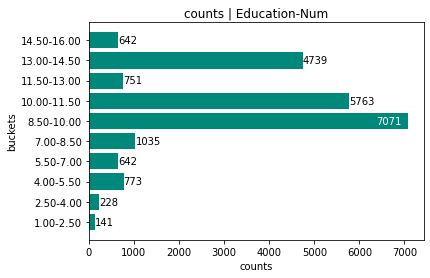
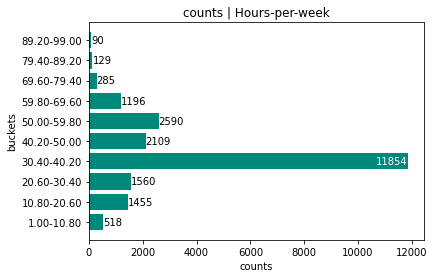
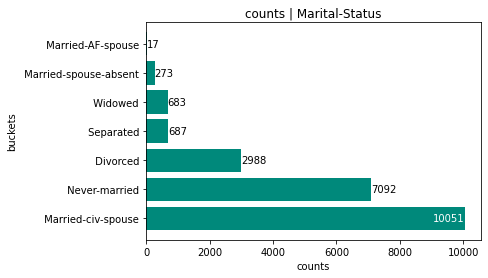
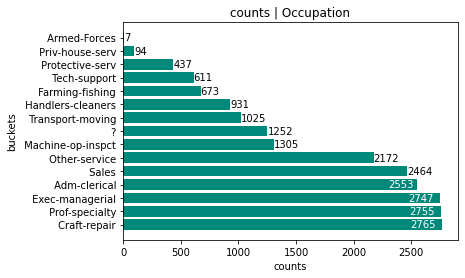
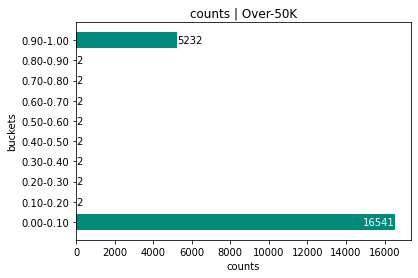
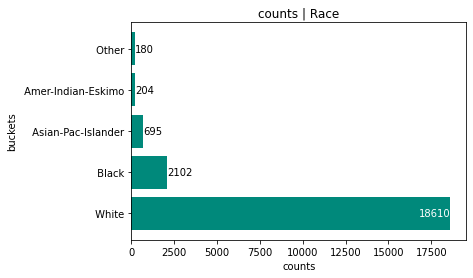
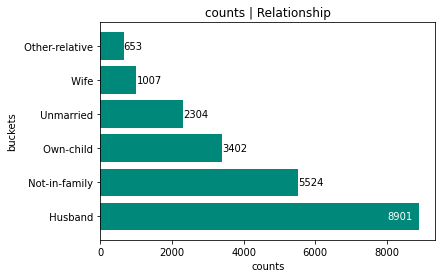
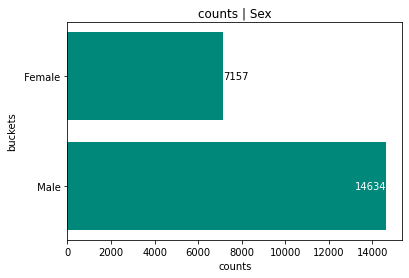
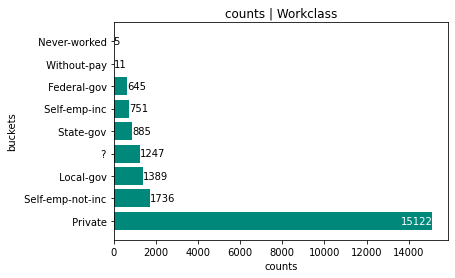
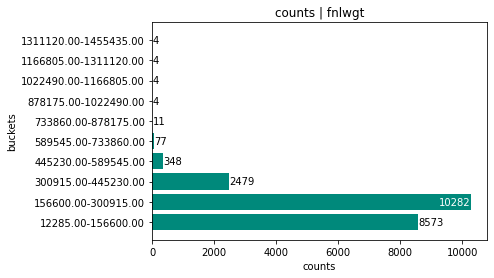
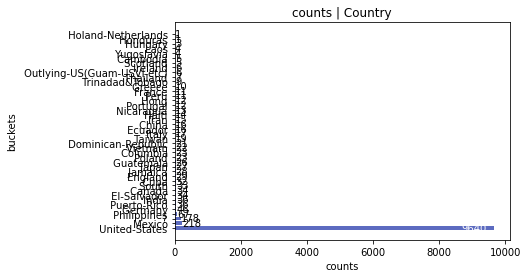
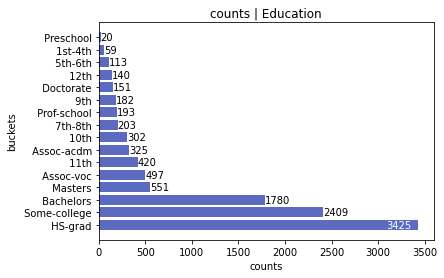
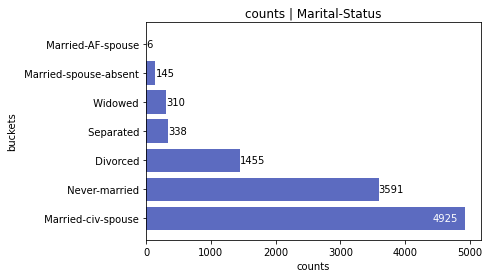
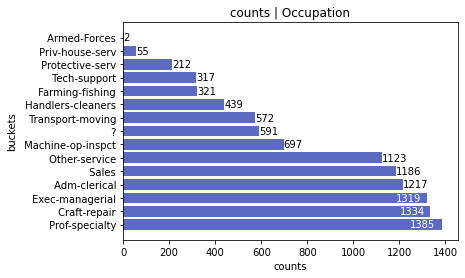
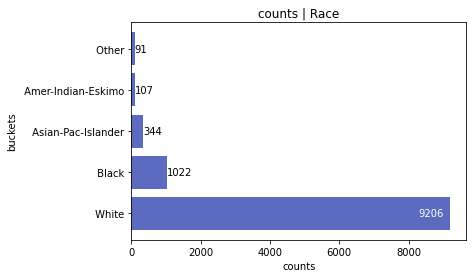
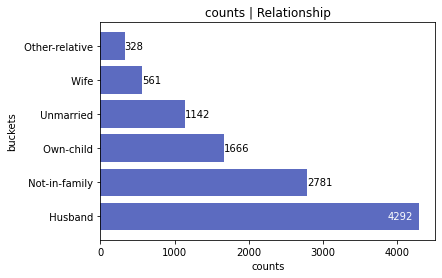
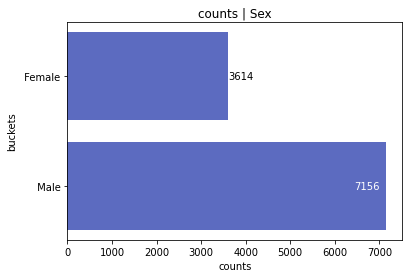
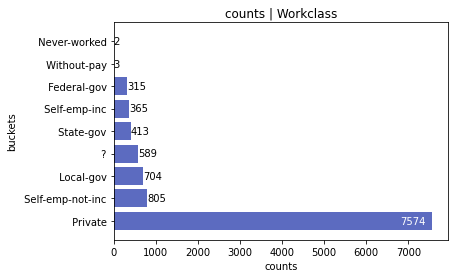
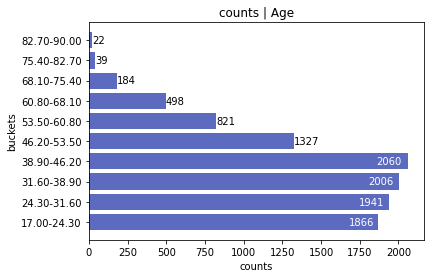
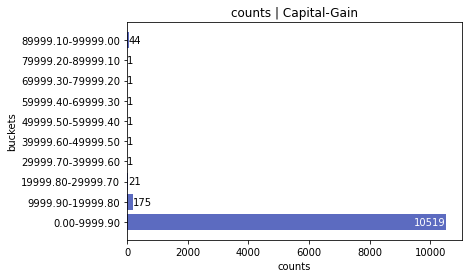
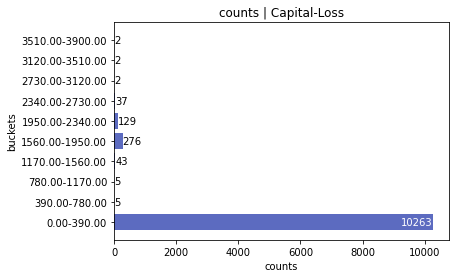
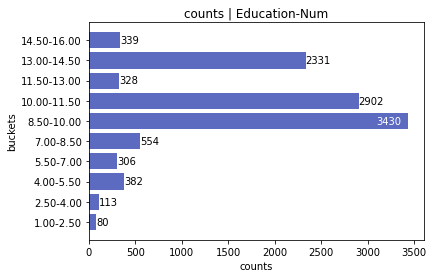
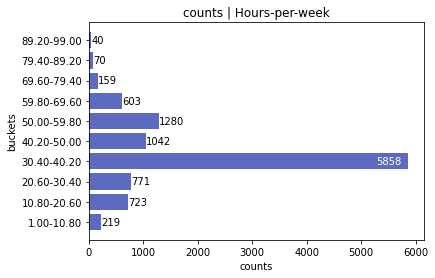
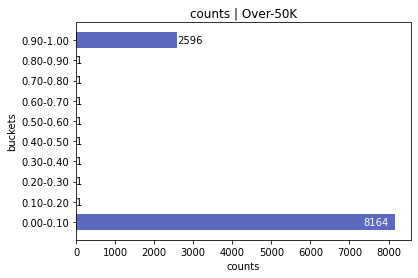
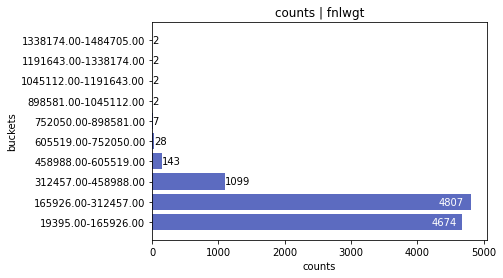
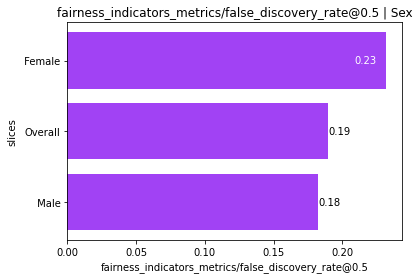
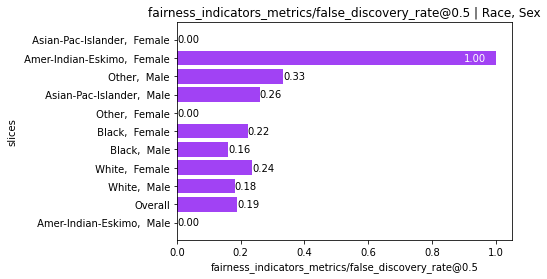
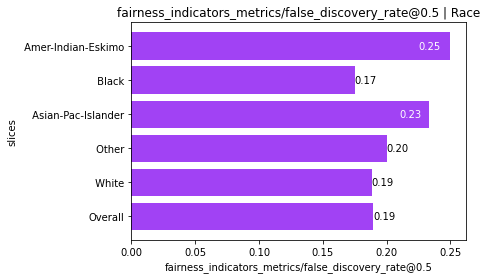
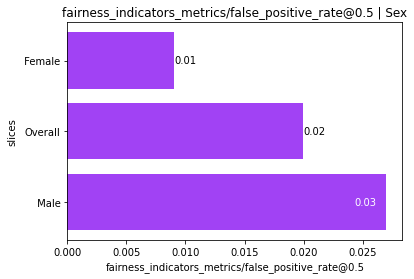
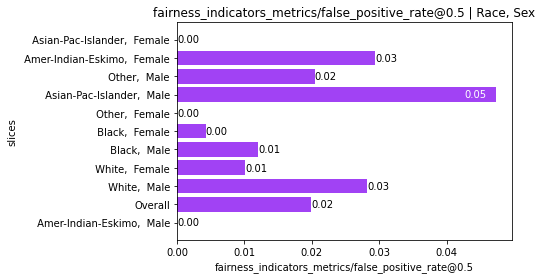
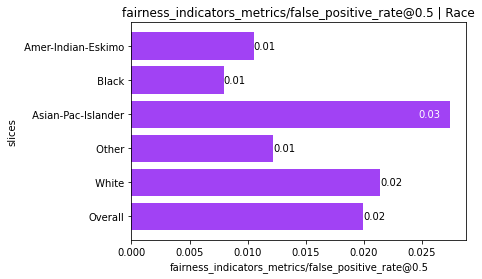
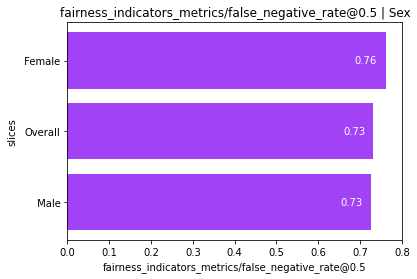
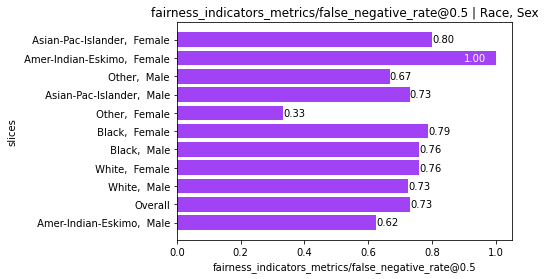
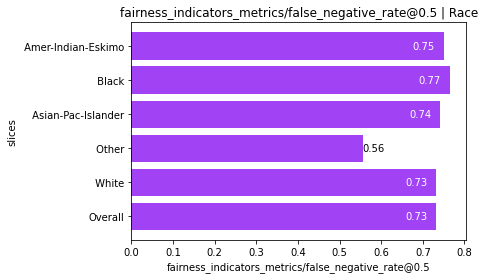
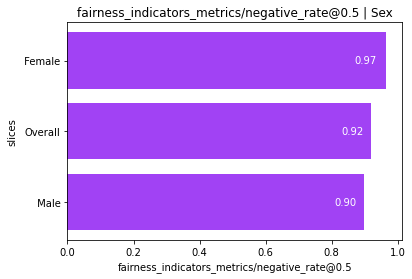
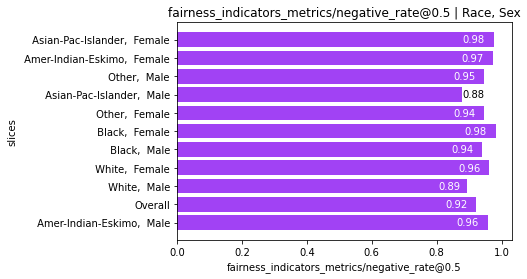
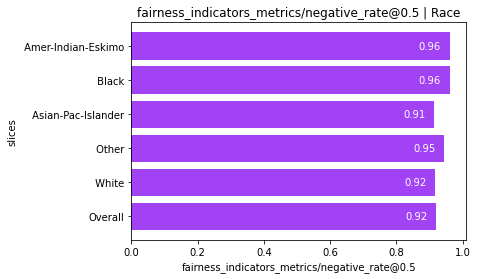
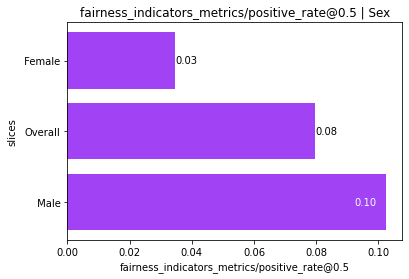
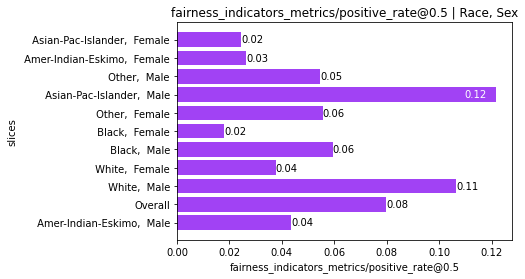
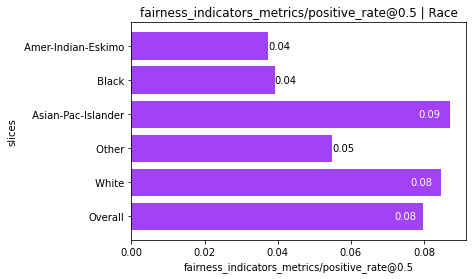
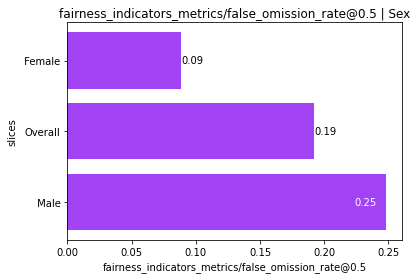
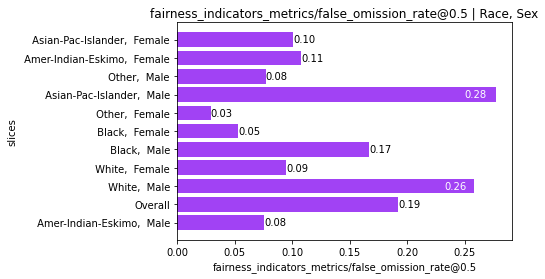
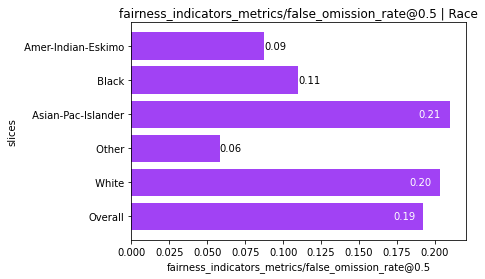
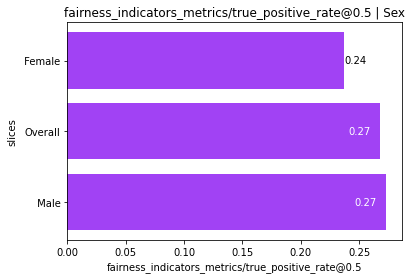
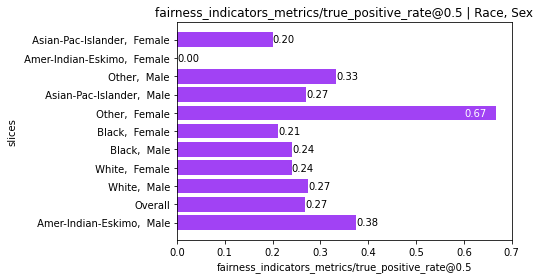
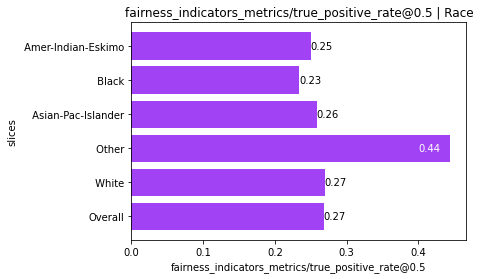
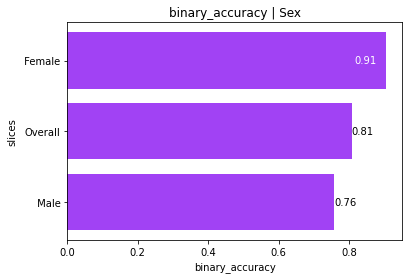
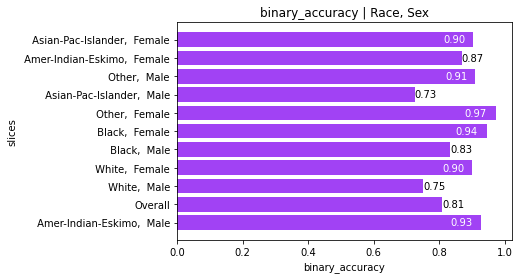
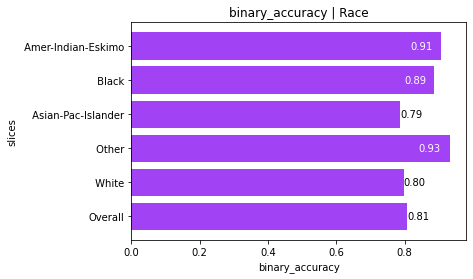
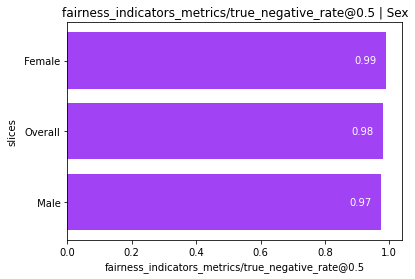
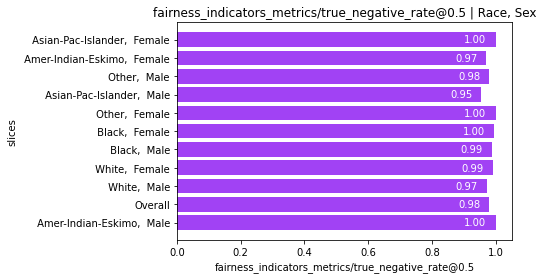
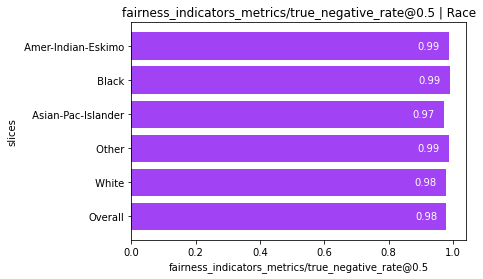
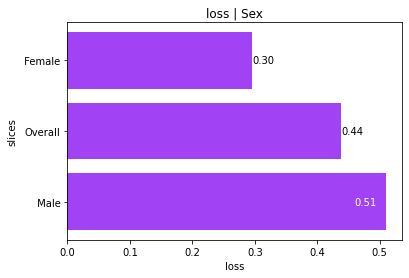
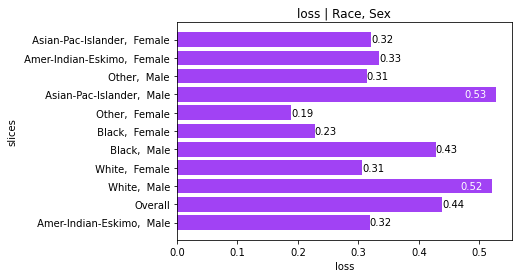
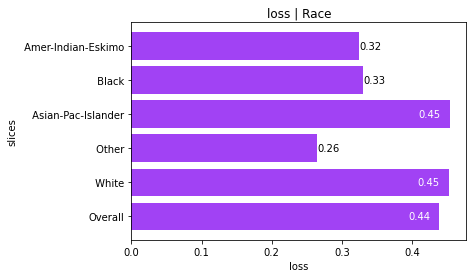
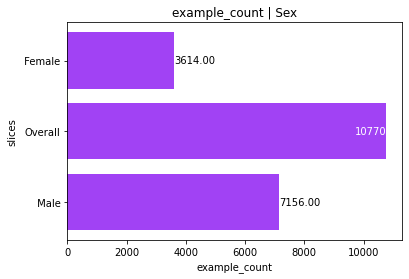
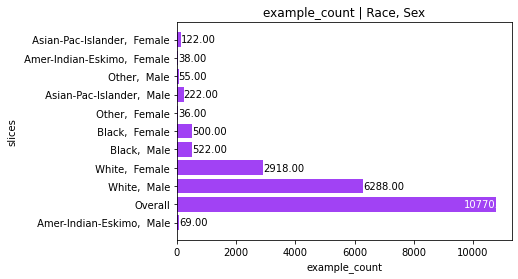
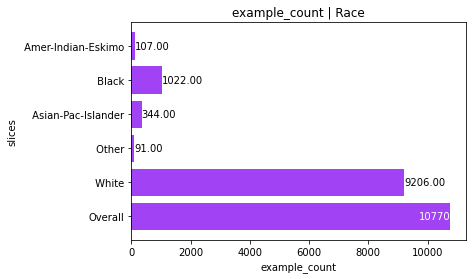

In [34]:
from IPython import display

mct_artifact = mct_gen.outputs['model_card'].get()[0]
mct_uri = mct_artifact.uri

print(os.listdir(mct_uri))

mct_path = os.path.join(mct_uri, 'model_cards', 'model_card.html')
with open(mct_path) as f:
  mct_content = f.read()


display.display(display.HTML(mct_content))